In [1]:
# Find unique number of classes
def get_classes(files):

    classes=set()
    for input_file in files:
        with open(input_file,'r') as f:
            for lines in f:
                if lines.startswith('#Dx'):
                    tmp = lines.split(': ')[1].split(',')
                    for c in tmp:
                        classes.add(c.strip())

    return sorted(classes)



# Find unique true labels
def get_true_labels(input_file,classes):

    classes_label = classes
    single_recording_labels=np.zeros(len(classes),dtype=int)


    with open(input_file,'r') as f:
        first_line = f.readline()
        recording_label=first_line.split(' ')[0]
        print(recording_label)
        for lines in f:
            if lines.startswith('#Dx'):
                tmp = lines.split(': ')[1].split(',')
                for c in tmp:
                    idx = classes.index(c.strip())
                    single_recording_labels[idx]=1

    return recording_label,classes_label,single_recording_labels






def compute_beta_score(labels, output, beta, num_classes, check_errors=True):

    # Check inputs for errors.
    if check_errors:
        if len(output) != len(labels):
            raise Exception('Numbers of outputs and labels must be the same.')

    # Populate contingency table.
    num_recordings = len(labels)

    fbeta_l = np.zeros(num_classes)
    gbeta_l = np.zeros(num_classes)
    fmeasure_l = np.zeros(num_classes)
    accuracy_l = np.zeros(num_classes)

    f_beta = 0
    g_beta = 0
    f_measure = 0
    accuracy = 0

    # Weight function
    C_l=np.ones(num_classes);

    for j in range(num_classes):
        tp = 0
        fp = 0
        fn = 0
        tn = 0

        for i in range(num_recordings):
            
            num_labels = np.sum(labels[i])
        
            if labels[i][j] and output[i][j]:
                tp += 1/num_labels
            elif not labels[i][j] and output[i][j]:
                fp += 1/num_labels
            elif labels[i][j] and not output[i][j]:
                fn += 1/num_labels
            elif not labels[i][j] and not output[i][j]:
                tn += 1/num_labels

        # Summarize contingency table.
        if ((1+beta**2)*tp + (fn*beta**2) + fp):
            fbeta_l[j] = float((1+beta**2)* tp) / float(((1+beta**2)*tp) + (fn*beta**2) + fp)
        else:
            fbeta_l[j] = 1.0

        if (tp + fp + beta * fn):
            gbeta_l[j] = float(tp) / float(tp + fp + beta*fn)
        else:
            gbeta_l[j] = 1.0

        if tp + fp + fn + tn:
            accuracy_l[j] = float(tp + tn) / float(tp + fp + fn + tn)
        else:
            accuracy_l[j] = 1.0

        if 2 * tp + fp + fn:
            fmeasure_l[j] = float(2 * tp) / float(2 * tp + fp + fn)
        else:
            fmeasure_l[j] = 1.0


    for i in range(num_classes):
        f_beta += fbeta_l[i]*C_l[i]
        g_beta += gbeta_l[i]*C_l[i]
        f_measure += fmeasure_l[i]*C_l[i]
        accuracy += accuracy_l[i]*C_l[i]


    f_beta = float(f_beta)/float(num_classes)
    g_beta = float(g_beta)/float(num_classes)
    f_measure = float(f_measure)/float(num_classes)
    accuracy = float(accuracy)/float(num_classes)


    return accuracy,f_measure,f_beta,g_beta

    


def compute_auc(labels, probabilities, num_classes, check_errors=True):


    # Check inputs for errors.
    if check_errors:
        if len(labels) != len(probabilities):
            raise Exception('Numbers of outputs and labels must be the same.')

    find_NaNs = np.isnan(probabilities);
    probabilities[find_NaNs] = 0;

    auroc_l = np.zeros(num_classes)
    auprc_l = np.zeros(num_classes)

    auroc = 0
    auprc = 0

    # Weight function - this will change
    C_l=np.ones(num_classes);

    # Populate contingency table.
    num_recordings = len(labels)

    for k in range(num_classes):
    

            # Find probabilities thresholds.
        thresholds = np.unique(probabilities[:,k])[::-1]
        if thresholds[0] != 1:
            thresholds = np.insert(thresholds, 0, 1)
        if thresholds[-1] == 0:
            thresholds = thresholds[:-1]

        m = len(thresholds)
    

        # Populate contingency table across probabilities thresholds.
        tp = np.zeros(m)
        fp = np.zeros(m)
        fn = np.zeros(m)
        tn = np.zeros(m)

        # Find indices that sort the predicted probabilities from largest to
        # smallest.
        idx = np.argsort(probabilities[:,k])[::-1]

        i = 0
        for j in range(m):
            # Initialize contingency table for j-th probabilities threshold.
            if j == 0:
                tp[j] = 0
                fp[j] = 0
                fn[j] = np.sum(labels[:,k])
                tn[j] = num_recordings - fn[j]
            else:
                tp[j] = tp[j - 1]
                fp[j] = fp[j - 1]
                fn[j] = fn[j - 1]
                tn[j] = tn[j - 1]
            # Update contingency table for i-th largest predicted probability.
            while i < num_recordings and probabilities[idx[i],k] >= thresholds[j]:
                if labels[idx[i],k]:
                    tp[j] += 1
                    fn[j] -= 1
                else:
                    fp[j] += 1
                    tn[j] -= 1
                i += 1

        # Summarize contingency table.
        tpr = np.zeros(m)
        tnr = np.zeros(m)
        ppv = np.zeros(m)
        npv = np.zeros(m)


        for j in range(m):
            if tp[j] + fn[j]:
                tpr[j] = float(tp[j]) / float(tp[j] + fn[j])
            else:
                tpr[j] = 1
            if fp[j] + tn[j]:
                tnr[j] = float(tn[j]) / float(fp[j] + tn[j])
            else:
                tnr[j] = 1
            if tp[j] + fp[j]:
                ppv[j] = float(tp[j]) / float(tp[j] + fp[j])
            else:
                ppv[j] = 1
            if fn[j] + tn[j]:
                npv[j] = float(tn[j]) / float(fn[j] + tn[j])
            else:
                npv[j] = 1

        # Compute AUROC as the area under a piecewise linear function with TPR /
        # sensitivity (x-axis) and TNR / specificity (y-axis) and AUPRC as the area
        # under a piecewise constant with TPR / recall (x-axis) and PPV / precision
        # (y-axis).

        for j in range(m-1):
            auroc_l[k] += 0.5 * (tpr[j + 1] - tpr[j]) * (tnr[j + 1] + tnr[j])
            auprc_l[k] += (tpr[j + 1] - tpr[j]) * ppv[j + 1]


    for i in range(num_classes):
        auroc += auroc_l[i]*C_l[i]
        auprc += auprc_l[i]*C_l[i]

    auroc = float(auroc)/float(num_classes)
    auprc = float(auprc)/float(num_classes)

    
    return auroc, auprc


In [2]:
import numpy as np, os, os.path, sys

In [3]:
def evaluate_12ECG_io(label_directory, output_directory):

    # Set parameters.
    label_header       = '12ECGLabel'
    output_label_header  = 'OutputLabel'
    output_probability_header = 'OutputProbability'

    beta = 2
    labels=[]
    output_probabilities=[]

    # Find label and output files.
    label_files = []
    for f in os.listdir(label_directory):
        g = os.path.join(label_directory, f)
        if os.path.isfile(g) and not f.lower().startswith('.') and f.lower().endswith('hea'):
            label_files.append(g)
    label_files = sorted(label_files)

    output_files = []
    for f in os.listdir(output_directory):
        g = os.path.join(output_directory, f)
        if os.path.isfile(g) and not f.lower().startswith('.') and f.lower().endswith('csv'):
            output_files.append(g)
    output_files = sorted(output_files)

    if len(label_files) != len(output_files):
        raise Exception('Numbers of label and output files must be the same.')

    classes = get_classes(label_files)


    # Load labels and outputs.
    num_files = len(label_files)

    for k in range(num_files):

        recording_label,classes_label,single_recording_labels=get_true_labels(label_files[k],classes)
        
        with open(output_files[k],'r') as f:
            tmp_data = f.readlines()
        recording_output = tmp_data[0]
        classes_output = tmp_data[1].split(',')
        single_recording_output = np.array(tmp_data[2].split(','),np.int)
        single_probabilities_output = np.array(tmp_data[3].split(','),np.float64)

       # Check labels and output for errors.

        if not (len(classes_label) == len(classes_output)):
            raise Exception('Numbers of classes for a file must be the same.')
        
        if not (len(single_recording_labels) == len(single_recording_output) == len(single_probabilities_output)):
            raise Exception('Numbers of labels and output for a file must be the same.')

        labels.append(single_recording_labels)
        output_probabilities.append(single_probabilities_output)

    labels=np.array(labels)
    output_probabilities=np.array(output_probabilities)

    num_classes = len(classes_label)
    
    return labels, output_probabilities



In [4]:
labels , output_prob = evaluate_12ECG_io("./input_directory/","./output_directory/")

A0001
A0002
A0003
A0004
A0005
A0006
A0007
A0008
A0009
A0010
A0011
A0012
A0013
A0014
A0015
A0016
A0017
A0018
A0019
A0020
A0021
A0022
A0023
A0024
A0025
A0026
A0027
A0028
A0029
A0030
A0031
A0032
A0033
A0034
A0035
A0036
A0037
A0038
A0039
A0040
A0041
A0042
A0043
A0044
A0045
A0046
A0047
A0048
A0049
A0050
A0051
A0052
A0053
A0054
A0055
A0056
A0057
A0058
A0059
A0060
A0061
A0062
A0063
A0064
A0065
A0066
A0067
A0068
A0069
A0070
A0071
A0072
A0073
A0074
A0075
A0076
A0077
A0078
A0079
A0080
A0081
A0082
A0083
A0084
A0085
A0086
A0087
A0088
A0089
A0090
A0091
A0092
A0093
A0094
A0095
A0096
A0097
A0098
A0099
A0100
A0101
A0102
A0103
A0104
A0105
A0106
A0107
A0108
A0109
A0110
A0111
A0112
A0113
A0114
A0115
A0116
A0117
A0118
A0119
A0120
A0121
A0122
A0123
A0124
A0125
A0126
A0127
A0128
A0129
A0130
A0131
A0132
A0133
A0134
A0135
A0136
A0137
A0138
A0139
A0140
A0141
A0142
A0143
A0144
A0145
A0146
A0147
A0148
A0149
A0150
A0151
A0152
A0153
A0154
A0155
A0156
A0157
A0158
A0159
A0160
A0161
A0162
A0163
A0164
A0165
A0166
A016

A1466
A1467
A1468
A1469
A1470
A1471
A1472
A1473
A1474
A1475
A1476
A1477
A1478
A1479
A1480
A1481
A1482
A1483
A1484
A1485
A1486
A1487
A1488
A1489
A1490
A1491
A1492
A1493
A1494
A1495
A1496
A1497
A1498
A1499
A1500
A1501
A1502
A1503
A1504
A1505
A1506
A1507
A1508
A1509
A1510
A1511
A1512
A1513
A1514
A1515
A1516
A1517
A1518
A1519
A1520
A1521
A1522
A1523
A1524
A1525
A1526
A1527
A1528
A1529
A1530
A1531
A1532
A1533
A1534
A1535
A1536
A1537
A1538
A1539
A1540
A1541
A1542
A1543
A1544
A1545
A1546
A1547
A1548
A1549
A1550
A1551
A1552
A1553
A1554
A1555
A1556
A1557
A1558
A1559
A1560
A1561
A1562
A1563
A1564
A1565
A1566
A1567
A1568
A1569
A1570
A1571
A1572
A1573
A1574
A1575
A1576
A1577
A1578
A1579
A1580
A1581
A1582
A1583
A1584
A1585
A1586
A1587
A1588
A1589
A1590
A1591
A1592
A1593
A1594
A1595
A1596
A1597
A1598
A1599
A1600
A1601
A1602
A1603
A1604
A1605
A1606
A1607
A1608
A1609
A1610
A1611
A1612
A1613
A1614
A1615
A1616
A1617
A1618
A1619
A1620
A1621
A1622
A1623
A1624
A1625
A1626
A1627
A1628
A1629
A1630
A1631
A163

A2968
A2969
A2970
A2971
A2972
A2973
A2974
A2975
A2976
A2977
A2978
A2979
A2980
A2981
A2982
A2983
A2984
A2985
A2986
A2987
A2988
A2989
A2990
A2991
A2992
A2993
A2994
A2995
A2996
A2997
A2998
A2999
A3000
A3001
A3002
A3003
A3004
A3005
A3006
A3007
A3008
A3009
A3010
A3011
A3012
A3013
A3014
A3015
A3016
A3017
A3018
A3019
A3020
A3021
A3022
A3023
A3024
A3025
A3026
A3027
A3028
A3029
A3030
A3031
A3032
A3033
A3034
A3035
A3036
A3037
A3038
A3039
A3040
A3041
A3042
A3043
A3044
A3045
A3046
A3047
A3048
A3049
A3050
A3051
A3052
A3053
A3054
A3055
A3056
A3057
A3058
A3059
A3060
A3061
A3062
A3063
A3064
A3065
A3066
A3067
A3068
A3069
A3070
A3071
A3072
A3073
A3074
A3075
A3076
A3077
A3078
A3079
A3080
A3081
A3082
A3083
A3084
A3085
A3086
A3087
A3088
A3089
A3090
A3091
A3092
A3093
A3094
A3095
A3096
A3097
A3098
A3099
A3100
A3101
A3102
A3103
A3104
A3105
A3106
A3107
A3108
A3109
A3110
A3111
A3112
A3113
A3114
A3115
A3116
A3117
A3118
A3119
A3120
A3121
A3122
A3123
A3124
A3125
A3126
A3127
A3128
A3129
A3130
A3131
A3132
A3133
A313

A4334
A4335
A4336
A4337
A4338
A4339
A4340
A4341
A4342
A4343
A4344
A4345
A4346
A4347
A4348
A4349
A4350
A4351
A4352
A4353
A4354
A4355
A4356
A4357
A4358
A4359
A4360
A4361
A4362
A4363
A4364
A4365
A4366
A4367
A4368
A4369
A4370
A4371
A4372
A4373
A4374
A4375
A4376
A4377
A4378
A4379
A4380
A4381
A4382
A4383
A4384
A4385
A4386
A4387
A4388
A4389
A4390
A4391
A4392
A4393
A4394
A4395
A4396
A4397
A4398
A4399
A4400
A4401
A4402
A4403
A4404
A4405
A4406
A4407
A4408
A4409
A4410
A4411
A4412
A4413
A4414
A4415
A4416
A4417
A4418
A4419
A4420
A4421
A4422
A4423
A4424
A4425
A4426
A4427
A4428
A4429
A4430
A4431
A4432
A4433
A4434
A4435
A4436
A4437
A4438
A4439
A4440
A4441
A4442
A4443
A4444
A4445
A4446
A4447
A4448
A4449
A4450
A4451
A4452
A4453
A4454
A4455
A4456
A4457
A4458
A4459
A4460
A4461
A4462
A4463
A4464
A4465
A4466
A4467
A4468
A4469
A4470
A4471
A4472
A4473
A4474
A4475
A4476
A4477
A4478
A4479
A4480
A4481
A4482
A4483
A4484
A4485
A4486
A4487
A4488
A4489
A4490
A4491
A4492
A4493
A4494
A4495
A4496
A4497
A4498
A4499
A450

A5733
A5734
A5735
A5736
A5737
A5738
A5739
A5740
A5741
A5742
A5743
A5744
A5745
A5746
A5747
A5748
A5749
A5750
A5751
A5752
A5753
A5754
A5755
A5756
A5757
A5758
A5759
A5760
A5761
A5762
A5763
A5764
A5765
A5766
A5767
A5768
A5769
A5770
A5771
A5772
A5773
A5774
A5775
A5776
A5777
A5778
A5779
A5780
A5781
A5782
A5783
A5784
A5785
A5786
A5787
A5788
A5789
A5790
A5791
A5792
A5793
A5794
A5795
A5796
A5797
A5798
A5799
A5800
A5801
A5802
A5803
A5804
A5805
A5806
A5807
A5808
A5809
A5810
A5811
A5812
A5813
A5814
A5815
A5816
A5817
A5818
A5819
A5820
A5821
A5822
A5823
A5824
A5825
A5826
A5827
A5828
A5829
A5830
A5831
A5832
A5833
A5834
A5835
A5836
A5837
A5838
A5839
A5840
A5841
A5842
A5843
A5844
A5845
A5846
A5847
A5848
A5849
A5850
A5851
A5852
A5853
A5854
A5855
A5856
A5857
A5858
A5859
A5860
A5861
A5862
A5863
A5864
A5865
A5866
A5867
A5868
A5869
A5870
A5871
A5872
A5873
A5874
A5875
A5876
A5877
A5878
A5879
A5880
A5881
A5882
A5883
A5884
A5885
A5886
A5887
A5888
A5889
A5890
A5891
A5892
A5893
A5894
A5895
A5896
A5897
A5898
A589

In [5]:
threshold = np.linspace(0,1,101)

In [6]:
range(len(threshold))

range(0, 101)

In [7]:
output_prob[1]

array([0.25026935, 0.38396975, 0.07866517, 0.6474546 , 0.31687286,
       0.1930061 , 0.51334566, 0.30475253, 0.08376478])

In [8]:
beta = 2
num_classes = 9
scoring_values=[]
for i in range(len(threshold)):
    output = np.empty(shape=(6877,9)) 
    for j in range(output_prob.shape[0]):
        for k in range(output_prob.shape[1]):
            if output_prob[j][k] > threshold[i]:
                output[j][k] = 1
            else:
                output[j][k] = 0
            
    accuracy,f_measure,Fbeta_measure,Gbeta_measure = compute_beta_score(labels, output, beta, num_classes)
    auroc,auprc = compute_auc(labels, output_prob,num_classes)
    geomean = (Fbeta_measure + Gbeta_measure)/2
    print("--------------------------------------")
    print("Threshold = {:0.2f}".format(threshold[i]))
    print("AUROC|AUPRC|Accuracy|F measure|F2|G2")
    print(auroc,auprc,accuracy,f_measure,Fbeta_measure,Gbeta_measure)
    print("overall score:")
    print(geomean)
    print("--------------------------------------")
    scoring_values.append(geomean)
    
        


--------------------------------------
Threshold = 0.00
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.11511164674768172 0.20051686711001473 0.3678751349073622 0.11511164674768172
overall score:
0.24149339082752194
--------------------------------------
--------------------------------------
Threshold = 0.01
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.11529577181882093 0.20052754137286966 0.36789761177552444 0.11511731760392066
overall score:
0.24150746468972256
--------------------------------------
--------------------------------------
Threshold = 0.02
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.12070235345318202 0.20085110628185637 0.3685756806667658 0.11528959436817034
overall score:
0.24193263751746807
--------------------------------------
--------------------------------------
Threshold = 0.03
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.13678818921361

--------------------------------------
Threshold = 0.30
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.7452127481503799 0.5286984564808034 0.6586301505354768 0.34915172228351216
overall score:
0.5038909364094944
--------------------------------------
--------------------------------------
Threshold = 0.31
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.7570218606675372 0.5359226420822034 0.6605842291337588 0.3549668246653469
overall score:
0.5077755268995529
--------------------------------------
--------------------------------------
Threshold = 0.32
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.7681865354357069 0.5442366201582484 0.6637235983335512 0.3613724975441048
overall score:
0.512548047938828
--------------------------------------
--------------------------------------
Threshold = 0.33
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.7797194603461551 0.54986601

--------------------------------------
Threshold = 0.60
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.927705801613605 0.5584493527592005 0.54283488829268 0.3578800881039776
overall score:
0.45035748819832877
--------------------------------------
--------------------------------------
Threshold = 0.61
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.9294131431823506 0.5530328184718806 0.5338597129140354 0.35285273835919967
overall score:
0.4433562256366176
--------------------------------------
--------------------------------------
Threshold = 0.62
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.930794081215895 0.5490849626916072 0.527065841398699 0.3487922699195882
overall score:
0.43792905565914364
--------------------------------------
--------------------------------------
Threshold = 0.63
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.9319741555354693 0.5432707354

--------------------------------------
Threshold = 0.90
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.9060125205048374 0.13776823226908927 0.11057493239873771 0.06419015422835546
overall score:
0.08738254331354658
--------------------------------------
--------------------------------------
Threshold = 0.91
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.9036356332228581 0.12050968764429577 0.09586836176184563 0.054379089118878676
overall score:
0.07512372544036215
--------------------------------------
--------------------------------------
Threshold = 0.92
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.9008068025844465 0.10248113798642053 0.08013767017161955 0.043849938654671586
overall score:
0.061993804413145566
--------------------------------------
--------------------------------------
Threshold = 0.93
AUROC|AUPRC|Accuracy|F measure|F2|G2
0.9581252145523104 0.7972809236237537 0.897844062803

In [9]:
import matplotlib.pyplot as plt

In [10]:
scoring_values = np.array(scoring_values)

In [11]:
scoring_values.max()

0.5232033869405981

In [14]:
threshold[maxpoint]

array([0.4])

In [12]:
maxpoint=np.where(scoring_values ==scoring_values.max())

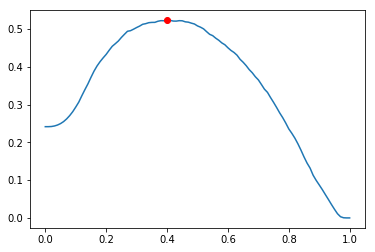

In [13]:
plt.plot(threshold,scoring_values)
plt.plot(threshold[maxpoint], scoring_values[maxpoint], 'ro')